This solution is built on the following notebooks. 

Reference: 
1. https://www.kaggle.com/code/mayer79/m5-forecast-poisson-loss-top-10
2. https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling

# Import packages

In [1]:
import pandas as pd
import numpy as np
import os

import models
import utils

from utils import TRAIN_DATASET

%load_ext autoreload
%autoreload 2

# Notebook settings

In [2]:
debug = False  # Use subsample data if debug=True

# Load data

In [3]:
data_dir = "data"
submission_dir = "submissions"
os.makedirs(submission_dir, exist_ok=True)

calendar = pd.read_csv(os.path.join(data_dir, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(data_dir, "sell_prices.csv"))
sample_submission_accuracy = pd.read_csv(os.path.join(data_dir, "sample_submission_accuracy.csv"))
sample_submission_uncertainty = pd.read_csv(os.path.join(data_dir, "sample_submission_uncertainty.csv"))
sales = pd.read_csv(os.path.join(data_dir, f"sales_train_{TRAIN_DATASET}.csv"))

In [4]:
sample_submission_accuracy['id']

0        HOBBIES_1_001_CA_1_validation
1        HOBBIES_1_002_CA_1_validation
2        HOBBIES_1_003_CA_1_validation
3        HOBBIES_1_004_CA_1_validation
4        HOBBIES_1_005_CA_1_validation
                     ...              
60975      FOODS_3_823_WI_3_evaluation
60976      FOODS_3_824_WI_3_evaluation
60977      FOODS_3_825_WI_3_evaluation
60978      FOODS_3_826_WI_3_evaluation
60979      FOODS_3_827_WI_3_evaluation
Name: id, Length: 60980, dtype: object

In [5]:
sample_submission_uncertainty[(sample_submission_uncertainty['id'].str.startswith('HOBBIES_1_001_CA_1'))]['id']

12350     HOBBIES_1_001_CA_1_0.005_validation
55190     HOBBIES_1_001_CA_1_0.025_validation
98030     HOBBIES_1_001_CA_1_0.165_validation
140870    HOBBIES_1_001_CA_1_0.250_validation
183710    HOBBIES_1_001_CA_1_0.500_validation
226550    HOBBIES_1_001_CA_1_0.750_validation
269390    HOBBIES_1_001_CA_1_0.835_validation
312230    HOBBIES_1_001_CA_1_0.975_validation
355070    HOBBIES_1_001_CA_1_0.995_validation
397910    HOBBIES_1_001_CA_1_0.005_evaluation
440750    HOBBIES_1_001_CA_1_0.025_evaluation
483590    HOBBIES_1_001_CA_1_0.165_evaluation
526430    HOBBIES_1_001_CA_1_0.250_evaluation
569270    HOBBIES_1_001_CA_1_0.500_evaluation
612110    HOBBIES_1_001_CA_1_0.750_evaluation
654950    HOBBIES_1_001_CA_1_0.835_evaluation
697790    HOBBIES_1_001_CA_1_0.975_evaluation
740630    HOBBIES_1_001_CA_1_0.995_evaluation
Name: id, dtype: object

In [6]:
# Quantiles required by M5 uncertainty
q_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.750, 0.835, 0.975, 0.995]

## Prepare data

In [7]:
calendar = utils.prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [8]:
sales = sales[:1000] if debug else sales

In [9]:
x_train, x_valid, y_train, y_valid, test, features = utils.prepare_training_data(sales, calendar, selling_prices, drop_d=1000-28)

In [10]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, test.shape

((24312726, 28), (2701414, 28), (24312726,), (2701414,), (2561160, 31))

In [11]:
x_valid

,item_id,store_id,lag_t7,sell_price,rolling_mean_lag2_w7,snap,dept_id,rolling_mean_lag28_w7,wday,rolling_mean_lag1_w7,...,rolling_mean_lag28_w28,lag_t2,rolling_mean_lag3_w7,rolling_mean_lag2_w28,month,year,lag_t28,rolling_mean_lag7_w28,state_id,lag_t3
25989676,1220,7,2.0,2.48,8.857142,0,3,6.857143,5,7.428571,...,12.285714,8.0,10.142858,7.964286,1,2016,7.0,7.642857,2,10.0
25989677,1220,8,2.0,2.48,4.857143,0,3,3.571429,5,4.285714,...,4.464286,3.0,4.714286,4.035714,1,2016,7.0,3.714286,3,7.0
25989678,1220,9,4.0,2.48,2.571429,0,3,0.000000,5,2.285714,...,1.142857,1.0,2.571429,0.928571,1,2016,0.0,0.500000,3,7.0
25989679,1220,10,5.0,2.48,8.571428,0,3,8.285714,5,7.714286,...,10.285714,3.0,10.000000,9.857142,1,2016,9.0,9.750000,3,13.0
25989680,1221,1,0.0,1.74,1.714286,0,3,1.428571,5,1.857143,...,1.464286,2.0,1.571429,1.750000,1,2016,1.0,1.607143,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28691085,3049,6,1.0,5.94,0.428571,0,7,0.571429,2,0.285714,...,0.357143,0.0,0.428571,0.321429,4,2016,1.0,0.392857,2,0.0
28691086,3049,7,0.0,5.94,0.000000,0,7,0.000000,2,0.000000,...,0.178571,0.0,0.000000,0.178571,4,2016,0.0,0.178571,2,0.0
28691087,3049,8,0.0,5.94,0.000000,0,7,0.000000,2,0.000000,...,0.071429,0.0,0.142857,0.035714,4,2016,0.0,0.035714,3,0.0
28691088,3049,9,0.0,5.94,0.142857,0,7,0.000000,2,0.142857,...,0.035714,0.0,0.142857,0.035714,4,2016,0.0,0.000000,3,1.0


In [12]:
y_valid

25989676    7.0
25989677    3.0
25989678    4.0
25989679    7.0
25989680    2.0
           ... 
28691085    0.0
28691086    0.0
28691087    0.0
28691088    0.0
28691089    0.0
Name: demand, Length: 2701414, dtype: float32

In [13]:
test

,id,item_id,store_id,state_id,dept_id,cat_id,d,demand,lag_t1,rolling_mean_lag1_w7,...,rolling_mean_lag28_w7,rolling_mean_lag28_w28,wday,month,year,event_name_1,event_name_2,snap,sell_price,sell_price_last_week
26983650,FOODS_1_001_CA_1,1,1,1,1,1,1858,1.0,0.0,0.142857,...,1.000000,0.500000,3,2,2016,1,1,0,2.24,2.24
26983651,FOODS_1_001_CA_2,1,2,1,1,1,1858,0.0,0.0,0.714286,...,1.000000,1.035714,3,2,2016,1,1,0,2.24,2.24
26983652,FOODS_1_001_CA_3,1,3,1,1,1,1858,1.0,5.0,1.714286,...,0.571429,0.892857,3,2,2016,1,1,0,2.24,2.24
26983653,FOODS_1_001_CA_4,1,4,1,1,1,1858,0.0,0.0,0.000000,...,0.000000,0.142857,3,2,2016,1,1,0,2.24,2.24
26983654,FOODS_1_001_TX_1,1,5,2,1,1,1858,0.0,0.0,0.285714,...,0.000000,0.714286,3,2,2016,1,1,0,2.24,2.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29544805,HOUSEHOLD_2_516_TX_2,3049,6,2,7,3,1941,NaN,NaN,NaN,...,0.142857,0.285714,2,5,2016,1,1,0,5.94,5.94
29544806,HOUSEHOLD_2_516_TX_3,3049,7,2,7,3,1941,NaN,NaN,NaN,...,0.000000,0.178571,2,5,2016,1,1,0,5.94,5.94
29544807,HOUSEHOLD_2_516_WI_1,3049,8,3,7,3,1941,NaN,NaN,NaN,...,0.000000,0.035714,2,5,2016,1,1,0,5.94,5.94
29544808,HOUSEHOLD_2_516_WI_2,3049,9,3,7,3,1941,NaN,NaN,NaN,...,0.142857,0.035714,2,5,2016,1,1,0,5.94,5.94


In [14]:
if debug:
    x_train, y_train = x_train[:10000], y_train[:10000]
    x_valid, y_valid = x_valid[:1000], y_valid[:1000]

    # test = test[:100]

# Training and Evaluation

## Mean prediction

### Hurdle Model

In [15]:
poisson_ts_model = models.HurdleLGBM().fit(x_train, x_valid, y_train, y_valid)

Stage 1: Training binary classifier for P(Y = 0)...
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.494649
[100]	valid_0's binary_logloss: 0.492639
[150]	valid_0's binary_logloss: 0.491938
[200]	valid_0's binary_logloss: 0.491524
[250]	valid_0's binary_logloss: 0.491294
[300]	valid_0's binary_logloss: 0.491069
[350]	valid_0's binary_logloss: 0.4909
[400]	valid_0's binary_logloss: 0.490731
[450]	valid_0's binary_logloss: 0.49061
[500]	valid_0's binary_logloss: 0.490544
[550]	valid_0's binary_logloss: 0.490458
[600]	valid_0's binary_logloss: 0.490365
[650]	valid_0's binary_logloss: 0.490264
[700]	valid_0's binary_logloss: 0.49018
[750]	valid_0's binary_logloss: 0.490121
[800]	valid_0's binary_logloss: 0.490051
[850]	valid_0's binary_logloss: 0.48999
[900]	valid_0's binary_logloss: 0.489962
[950]	valid_0's binary_logloss: 0.489905
[1000]	valid_0's binary_logloss: 0.48987
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_

In [16]:
pred = utils.forecast_point_horizon(poisson_ts_model, test, features)

d:\Files\StudyInHongKong\HKUST\Courses_UST\MATH5470\FinalCode\m5_baseline\m5-forecasting-main\utils.py:175: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.68018619 0.63864419 0.54234057 ... 0.08181204 0.06999724 0.04957429]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pred.loc[pred.d==day, "demand"] = pred_res


In [17]:
utils.save_accuracy_submission(
    pred, 
    cols_template=sample_submission_accuracy, 
    filepath=os.path.join(submission_dir, f"submission_accuracy_pois_ts_{TRAIN_DATASET}.csv")
)


True

In [18]:
submission_accuracy = pd.read_csv(os.path.join(submission_dir, f"submission_accuracy_pois_ts_{TRAIN_DATASET}.csv"))

submission_accuracy

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.680186,0.705338,0.702317,0.693110,0.774453,0.815055,0.825676,0.777992,0.752454,...,0.719905,0.822977,0.795215,0.673432,0.658745,0.657269,0.626498,0.699204,0.775479,0.749268
1,FOODS_1_001_CA_2_validation,0.638644,0.639773,0.658328,0.677307,0.742323,0.799968,0.898997,0.746033,0.730372,...,0.781981,0.876209,0.831514,0.667103,0.643406,0.645910,0.642954,0.688377,0.775020,0.780931
2,FOODS_1_001_CA_3_validation,0.542341,0.607064,0.637821,0.651177,0.686928,0.806205,0.783036,0.701357,0.687000,...,0.714908,0.804497,0.781881,0.638418,0.610136,0.611998,0.606042,0.640536,0.689113,0.688269
3,FOODS_1_001_CA_4_validation,0.413033,0.391135,0.404185,0.406630,0.430426,0.446670,0.462794,0.402629,0.406997,...,0.409035,0.443405,0.445811,0.403331,0.367222,0.353467,0.365254,0.407885,0.405323,0.404786
4,FOODS_1_001_TX_1_validation,0.050131,0.263902,0.306690,0.352779,0.409465,0.380098,0.394065,0.338103,0.358661,...,0.376856,0.354386,0.336244,0.267624,0.269576,0.263701,0.265671,0.302217,0.320638,0.336273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.274455,0.252473,0.267529,0.309452,0.314276,0.382291,0.386047,0.289278,0.292344,...,0.311579,0.385588,0.394945,0.284273,0.270764,0.285668,0.272564,0.297393,0.344747,0.321805
30486,HOUSEHOLD_2_516_TX_3_validation,0.147996,0.194223,0.232510,0.187359,0.216350,0.212757,0.195270,0.157236,0.181833,...,0.258807,0.288665,0.278577,0.261056,0.238678,0.252824,0.263281,0.310779,0.243746,0.238345
30487,HOUSEHOLD_2_516_WI_1_validation,0.081812,0.092643,0.105623,0.116229,0.138358,0.194873,0.175186,0.133426,0.133762,...,0.168128,0.172648,0.153511,0.116550,0.114662,0.118563,0.120875,0.159962,0.196040,0.183995
30488,HOUSEHOLD_2_516_WI_2_validation,0.069997,0.090681,0.098655,0.095155,0.115192,0.125828,0.149203,0.127628,0.125718,...,0.157261,0.179184,0.169070,0.148390,0.149157,0.150357,0.136881,0.136000,0.144539,0.138563


In [19]:
# Recursive quantile forecasts
pred_per_q_poisson_ts = utils.forecast_quantile_horizon(poisson_ts_model, test, features, q_levels)

# Convert to submission file format
utils.save_uncertainty_submission(
    pred_per_q_poisson_ts,
    cols_template=sample_submission_uncertainty,
    filepath=os.path.join(submission_dir, f"submission_uncertainty_pois_ts_{TRAIN_DATASET}.csv")
)

True

In [20]:
submission_uncertainty_pois_ts = pd.read_csv(os.path.join(submission_dir, f"submission_uncertainty_pois_ts_{TRAIN_DATASET}.csv"))

submission_uncertainty_pois_ts

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_0.005_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FOODS_1_001_CA_1_0.025_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FOODS_1_001_CA_1_0.165_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FOODS_1_001_CA_1_0.250_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FOODS_1_001_CA_1_0.500_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274405,HOUSEHOLD_2_516_WI_3_0.500_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274406,HOUSEHOLD_2_516_WI_3_0.750_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274407,HOUSEHOLD_2_516_WI_3_0.835_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274408,HOUSEHOLD_2_516_WI_3_0.975_validation,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,...,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.02494
[200]	valid_0's rmse: 1.99892
[300]	valid_0's rmse: 1.98509
[400]	valid_0's rmse: 1.97981
[500]	valid_0's rmse: 1.97838
[600]	valid_0's rmse: 1.97514
[700]	valid_0's rmse: 1.97241
[800]	valid_0's rmse: 1.97101
[900]	valid_0's rmse: 1.96959
[1000]	valid_0's rmse: 1.96831
[1100]	valid_0's rmse: 1.96512
[1200]	valid_0's rmse: 1.96442
[1300]	valid_0's rmse: 1.96328
[1400]	valid_0's rmse: 1.96242
[1500]	valid_0's rmse: 1.96028
[1600]	valid_0's rmse: 1.95923
[1700]	valid_0's rmse: 1.95857
[1800]	valid_0's rmse: 1.95879
[1900]	valid_0's rmse: 1.95868
[2000]	valid_0's rmse: 1.95878
Did not meet early stopping. Best iteration is:
[1926]	valid_0's rmse: 1.95813


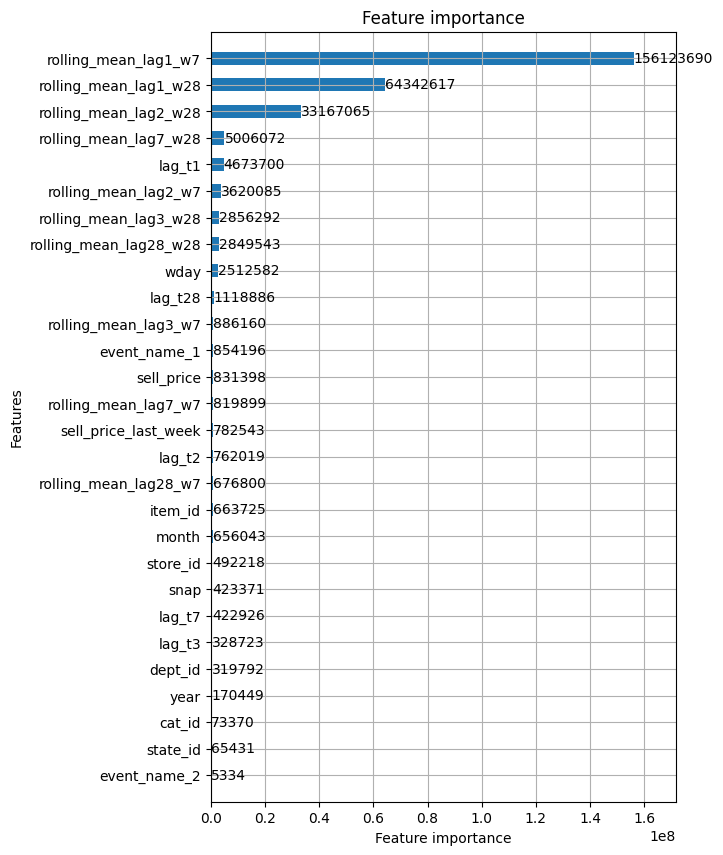

In [21]:
lgbm = models.LGBM().fit(x_train, x_valid, y_train, y_valid)

In [22]:
pred = utils.forecast_point_horizon(lgbm, test, features)

d:\Files\StudyInHongKong\HKUST\Courses_UST\MATH5470\FinalCode\m5_baseline\m5-forecasting-main\utils.py:175: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.92457658 1.25393724 0.85831928 ... 0.06821488 0.07463861 0.03273991]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pred.loc[pred.d==day, "demand"] = pred_res


In [23]:
pd.concat([test[test['d'] >= utils.FIRST]['demand'], pred[pred['d'] >= utils.FIRST]['demand']], axis=1)

,demand,demand
28691090,NaN,0.924577
28691091,NaN,1.253937
28691092,NaN,0.858319
28691093,NaN,0.493282
28691094,NaN,0.065146
...,...,...
29544805,NaN,0.369457
29544806,NaN,0.224813
29544807,NaN,0.151865
29544808,NaN,0.139185


In [24]:
utils.save_accuracy_submission(
    pred, 
    cols_template=sample_submission_accuracy, 
    filepath=os.path.join(submission_dir, f"submission_accuracy_lgbm_{TRAIN_DATASET}.csv")
)

True

In [25]:
submission_accuracy = pd.read_csv(os.path.join(submission_dir, f"submission_accuracy_lgbm_{TRAIN_DATASET}.csv"))

submission_accuracy

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.924577,0.935985,0.943970,0.935631,1.165665,1.289168,1.299374,1.110636,1.027344,...,1.105324,1.390919,1.256540,1.051491,0.973604,0.952861,0.948629,1.107884,1.358870,1.302625
1,FOODS_1_001_CA_2_validation,1.253937,1.082316,1.040455,1.146716,1.273049,1.618757,1.831210,1.188648,1.135936,...,1.411323,1.853898,1.950946,1.213254,1.158165,1.169680,1.220920,1.360266,1.718532,1.585904
2,FOODS_1_001_CA_3_validation,0.858319,1.013302,1.055876,1.032426,1.094393,1.288214,1.188134,1.000614,1.021501,...,1.155257,1.385838,1.471211,1.070979,1.066422,1.068515,1.085352,1.165165,1.248672,1.119352
3,FOODS_1_001_CA_4_validation,0.493282,0.476331,0.473005,0.478874,0.516958,0.538717,0.555536,0.459838,0.471507,...,0.530826,0.582202,0.574771,0.483284,0.486155,0.478617,0.488324,0.514439,0.574389,0.560681
4,FOODS_1_001_TX_1_validation,0.065146,0.337761,0.371507,0.475044,0.565919,0.686828,0.600872,0.449745,0.456305,...,0.445706,0.446530,0.413215,0.330379,0.348035,0.347875,0.350410,0.395050,0.454894,0.453628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.263250,0.260120,0.285037,0.291207,0.319453,0.391069,0.394283,0.295801,0.307318,...,0.321410,0.403363,0.402836,0.294316,0.280270,0.293246,0.288001,0.303272,0.362947,0.369457
30486,HOUSEHOLD_2_516_TX_3_validation,0.137417,0.176386,0.189471,0.174735,0.195515,0.214098,0.194693,0.145221,0.149339,...,0.234222,0.242971,0.234227,0.205207,0.197280,0.191945,0.211850,0.241046,0.226900,0.224813
30487,HOUSEHOLD_2_516_WI_1_validation,0.068215,0.094577,0.100467,0.112693,0.135135,0.179981,0.157094,0.109358,0.107639,...,0.131161,0.156710,0.140824,0.111598,0.111500,0.112074,0.115123,0.135704,0.168290,0.151865
30488,HOUSEHOLD_2_516_WI_2_validation,0.074639,0.099502,0.103166,0.105891,0.122725,0.148446,0.133607,0.104534,0.103652,...,0.156256,0.179077,0.170175,0.138910,0.139376,0.140764,0.117720,0.131317,0.148441,0.139185


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.96138
[200]	valid_0's rmse: 1.95276
[300]	valid_0's rmse: 1.94869
[400]	valid_0's rmse: 1.94761
[500]	valid_0's rmse: 1.946
[600]	valid_0's rmse: 1.94489
[700]	valid_0's rmse: 1.94475
[800]	valid_0's rmse: 1.94415
[900]	valid_0's rmse: 1.94443
Early stopping, best iteration is:
[761]	valid_0's rmse: 1.94384


d:\Files\StudyInHongKong\HKUST\Courses_UST\MATH5470\FinalCode\m5_baseline\m5-forecasting-main\utils.py:175: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.93659994 1.2697878  0.99506814 ... 0.06734735 0.06879081 0.0376712 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pred.loc[pred.d==day, "demand"] = pred_res


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.936600,0.939588,0.913930,0.907836,1.147105,1.313856,1.255270,1.087770,1.021977,...,1.116310,1.410592,1.277948,1.052104,0.981322,0.959526,0.965050,1.129156,1.380387,1.318006
1,FOODS_1_001_CA_2_validation,1.269788,1.073460,0.968053,1.082165,1.237479,1.593470,1.762552,1.185053,1.144640,...,1.345860,1.721765,1.826873,1.296692,1.149626,1.160430,1.205037,1.309087,1.722706,1.647625
2,FOODS_1_001_CA_3_validation,0.995068,1.016403,1.067714,1.019463,1.094558,1.387366,1.154723,0.984796,1.006451,...,1.147697,1.380583,1.499537,1.073070,1.147312,1.068533,1.076727,1.184083,1.330647,1.183289
3,FOODS_1_001_CA_4_validation,0.462386,0.456606,0.456568,0.478307,0.491173,0.502856,0.536380,0.435388,0.474197,...,0.488927,0.560738,0.548235,0.445345,0.439219,0.460305,0.459059,0.480013,0.520592,0.533752
4,FOODS_1_001_TX_1_validation,0.061174,0.370579,0.388817,0.474013,0.547494,0.621554,0.559240,0.440122,0.439042,...,0.399468,0.392503,0.381777,0.331409,0.335271,0.336981,0.350521,0.375341,0.415534,0.423892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.260659,0.253111,0.276685,0.271563,0.307186,0.375070,0.384466,0.291581,0.291707,...,0.317947,0.397808,0.394407,0.288679,0.268998,0.277166,0.279415,0.290978,0.359195,0.344141
30486,HOUSEHOLD_2_516_TX_3_validation,0.134503,0.168744,0.182105,0.174931,0.191801,0.214111,0.199981,0.145165,0.146090,...,0.222922,0.282900,0.277076,0.228256,0.201949,0.205092,0.219839,0.253242,0.242145,0.242235
30487,HOUSEHOLD_2_516_WI_1_validation,0.067347,0.087560,0.095763,0.107784,0.132061,0.162112,0.148359,0.102411,0.094288,...,0.127911,0.153588,0.130393,0.096740,0.101233,0.107044,0.110017,0.133082,0.163711,0.147505
30488,HOUSEHOLD_2_516_WI_2_validation,0.068791,0.091253,0.096702,0.096499,0.113948,0.120969,0.117577,0.093009,0.086034,...,0.146423,0.173627,0.158429,0.117441,0.122319,0.127856,0.109388,0.124487,0.132577,0.122148


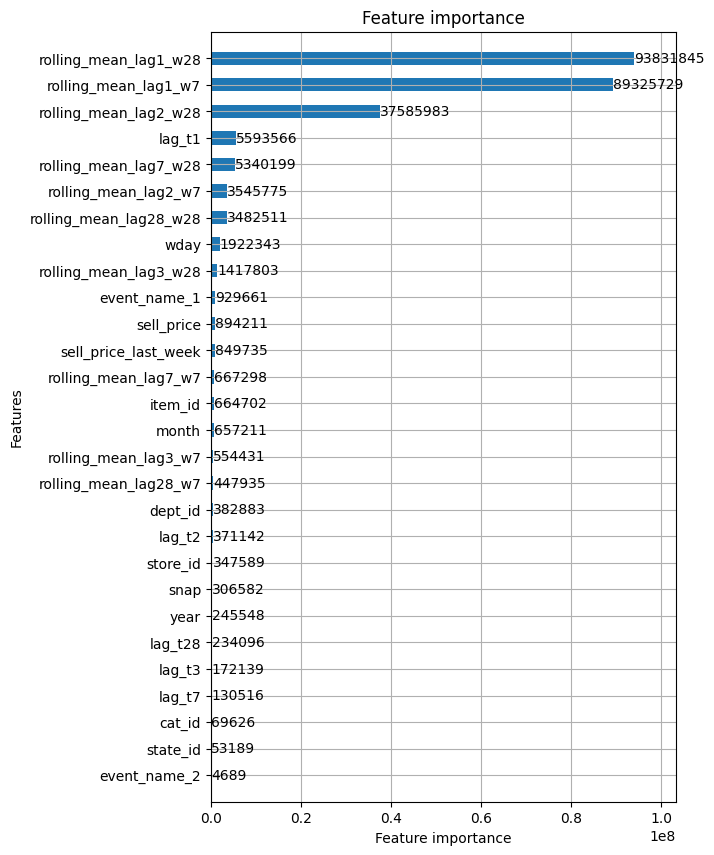

In [26]:
lgbmT = models.LGBMTweedie().fit(x_train, x_valid, y_train, y_valid)

pred = utils.forecast_point_horizon(lgbmT, test, features)
utils.save_accuracy_submission(
    pred, 
    cols_template=sample_submission_accuracy, 
    filepath=os.path.join(submission_dir, f"submission_accuracy_lgbmT_{TRAIN_DATASET}.csv")
)
submission_accuracy = pd.read_csv(os.path.join(submission_dir, f"submission_accuracy_lgbmT_{TRAIN_DATASET}.csv"))

submission_accuracy

In [27]:
# # Train Poisson model and inspect predictive quantiles
# zip_model = models.ZIPReg().fit(x_train, x_valid, y_train, y_valid)
# zip_model.model.summary()

## Uncertainty (quantile) prediction

In [28]:
# Train distributional LightGBM model (Negative Binomial) and inspect quantiles
# dist_lgbm = models.DistributionalLGBM().fit(x_train, x_valid, y_train, y_valid)

In [29]:
# Recursive quantile forecasts
# pred_per_q_dist_lgbm = utils.forecast_quantile_horizon(dist_lgbm, test, features, q_levels)

In [30]:
# pred_per_q_dist_lgbm[0.005]

In [31]:
# Convert to submission file format
# utils.save_uncertainty_submission(
#     pred_per_q_dist_lgbm,
#     cols_template=sample_submission_uncertainty,
#     filepath=os.path.join(submission_dir, f"submission_uncertainty_{TRAIN_DATASET}_dist_lgbm.csv")
# )

In [32]:
# submission_uncertainty_dist_lgbm = pd.read_csv(os.path.join(submission_dir, f"submission_uncertainty_{TRAIN_DATASET}_dist_lgbm.csv"))

# submission_uncertainty_dist_lgbm

In [ ]:
# Train NGBoost Poisson model and inspect predictive quantiles
ngb = models.NGBoostPoisson().fit(x_train, x_valid, y_train, y_valid)

[iter 0] loss=2.3867 val_loss=2.4186 scale=0.1250 norm=0.1650


In [37]:
pred = utils.forecast_point_horizon(ngb, test, features)

d:\Files\StudyInHongKong\HKUST\Courses_UST\MATH5470\FinalCode\m5_baseline\m5-forecasting-main\utils.py:175: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.98121024 1.20813951 0.60940785 ... 0.07478151 0.09509784 0.02995719]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pred.loc[pred.d==day, "demand"] = pred_res


In [38]:
utils.save_accuracy_submission(
    pred, 
    cols_template=sample_submission_accuracy, 
    filepath=os.path.join(submission_dir, f"submission_accuracy_ngb_{TRAIN_DATASET}.csv")
)
submission_accuracy = pd.read_csv(os.path.join(submission_dir, f"submission_accuracy_ngb_{TRAIN_DATASET}.csv"))

submission_accuracy

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.981210,0.955482,0.962401,0.962401,1.096663,1.273274,1.463215,1.171795,1.107612,...,1.205156,1.587461,1.577454,1.232989,1.116534,1.116534,1.116534,1.230526,1.587461,1.658633
1,FOODS_1_001_CA_2_validation,1.208140,1.128427,1.128427,1.128427,1.183634,1.401264,1.628356,1.267468,1.178709,...,1.279592,1.491079,1.779258,1.333796,1.258311,1.258311,1.281071,1.319514,1.748310,1.863820
2,FOODS_1_001_CA_3_validation,0.609408,0.754365,0.755114,0.810453,0.951384,1.133508,1.230507,0.987805,1.020452,...,1.230526,1.471151,1.592783,1.074254,1.025565,1.025565,1.025565,1.138457,1.316287,1.316287
3,FOODS_1_001_CA_4_validation,0.451368,0.353041,0.366306,0.366306,0.396049,0.453310,0.484851,0.413480,0.374816,...,0.403170,0.506642,0.531210,0.488701,0.376227,0.401433,0.401433,0.450763,0.527066,0.506026
4,FOODS_1_001_TX_1_validation,0.103045,0.100223,0.100093,0.100093,0.101583,0.240861,0.233332,0.187047,0.193710,...,0.227607,0.240640,0.231836,0.201752,0.196228,0.193740,0.193740,0.208138,0.225834,0.225834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.264502,0.251286,0.282975,0.270242,0.280012,0.314252,0.356455,0.288576,0.290741,...,0.298742,0.380970,0.360947,0.277021,0.280674,0.280674,0.269436,0.276852,0.332724,0.324999
30486,HOUSEHOLD_2_516_TX_3_validation,0.127224,0.123740,0.124765,0.109595,0.118294,0.169755,0.167596,0.136914,0.149242,...,0.236660,0.218961,0.204547,0.183770,0.178738,0.178738,0.178738,0.192925,0.197849,0.208974
30487,HOUSEHOLD_2_516_WI_1_validation,0.074782,0.070709,0.070709,0.070709,0.068844,0.071469,0.071469,0.064670,0.074167,...,0.128139,0.124186,0.124186,0.103988,0.102390,0.102390,0.102390,0.110676,0.123541,0.139367
30488,HOUSEHOLD_2_516_WI_2_validation,0.095098,0.094415,0.094415,0.088417,0.080272,0.083333,0.123407,0.105592,0.103238,...,0.137158,0.155084,0.155084,0.128870,0.140955,0.140955,0.125755,0.124854,0.139367,0.139367


In [34]:
# Recursive quantile forecasts
pred_per_q_ngb = utils.forecast_quantile_horizon(ngb, test, features, q_levels)

In [35]:
# Convert to submission file format
utils.save_uncertainty_submission(
    pred_per_q_ngb,
    cols_template=sample_submission_uncertainty,
    filepath=os.path.join(submission_dir, f"submission_uncertainty_ngb_{TRAIN_DATASET}.csv")
)

True

In [36]:
submission_uncertainty_ngb = pd.read_csv(os.path.join(submission_dir, f"submission_uncertainty_ngb_{TRAIN_DATASET}.csv"))

submission_uncertainty_ngb

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_0.005_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FOODS_1_001_CA_1_0.025_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FOODS_1_001_CA_1_0.165_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FOODS_1_001_CA_1_0.250_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FOODS_1_001_CA_1_0.500_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274405,HOUSEHOLD_2_516_WI_3_0.500_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274406,HOUSEHOLD_2_516_WI_3_0.750_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274407,HOUSEHOLD_2_516_WI_3_0.835_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274408,HOUSEHOLD_2_516_WI_3_0.975_validation,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,...,6.0,8.0,9.0,8.0,8.0,8.0,8.0,8.0,11.0,12.0
